In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

2024-10-23 20:25:37.814551: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 20:25:37.816421: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 20:25:37.857487: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 20:25:37.858146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 20:25:38.547679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load the training CSV file
train_data = pd.read_csv('datasets/sentiment/indonesian/train.csv')
# Load the validation CSV file
val_data = pd.read_csv('datasets/sentiment/indonesian/valid.csv')

In [3]:
# Ensure your CSV has 'text' and 'label' columns
train_texts = train_data['text'].values
train_labels = train_data['label'].values

val_texts = val_data['text'].values
val_labels = val_data['label'].values

# Preprocess the labels using Label Encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)  # Use the same encoder

# One-hot encode the labels for multi-class classification
num_classes = len(label_encoder.classes_)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes)
val_labels_one_hot = to_categorical(val_labels_encoded, num_classes)

In [4]:

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)  # Fit only on training data
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Pad sequences to ensure uniform input size
max_length = max(len(seq) for seq in train_sequences + val_sequences)  # Use both for max length
X_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_val = pad_sequences(val_sequences, maxlen=max_length, padding='post')

In [5]:
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization# Build the SimpleRNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_length))

# Optional convolutional layer to extract local features
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Simple RNN layer instead of LSTM
model.add(SimpleRNN(units=128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second SimpleRNN layer
model.add(SimpleRNN(units=64))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [6]:
from keras.callbacks import ModelCheckpoint
# Add model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    'best_model_val_accuracy_{val_accuracy:.4f}.h5',  # File path to save the model
    monitor='val_accuracy',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='max',  # Minimize validation loss
    verbose=1  # Print a message when the model is saved
)

In [7]:
# Fit the model using the custom validation data
history = model.fit(X_train, train_labels_one_hot, 
                    epochs=1000, batch_size=32, 
                    validation_data=(X_val, val_labels_one_hot),
                    callbacks=[model_checkpoint])

Epoch 1/1000
13/16 [=======================>......] - ETA: 0s - loss: 1.2048 - accuracy: 0.3606
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to best_model_val_accuracy_0.4800.h5
16/16 [==============================] - 3s 39ms/step - loss: 1.1810 - accuracy: 0.3700 - val_loss: 1.0416 - val_accuracy: 0.4800
Epoch 2/1000
 9/16 [===============>..............] - ETA: 0s - loss: 1.1334 - accuracy: 0.4549

/home/fachrikid/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/16 [=======================>......] - ETA: 0s - loss: 1.1149 - accuracy: 0.4351
Epoch 2: val_accuracy did not improve from 0.48000
16/16 [==============================] - 0s 17ms/step - loss: 1.0770 - accuracy: 0.4500 - val_loss: 1.0156 - val_accuracy: 0.4400
Epoch 3/1000
13/16 [=======================>......] - ETA: 0s - loss: 0.9923 - accuracy: 0.4760
Epoch 3: val_accuracy did not improve from 0.48000
16/16 [==============================] - 0s 15ms/step - loss: 1.0232 - accuracy: 0.4620 - val_loss: 1.0301 - val_accuracy: 0.4500
Epoch 4/1000
13/16 [=======================>......] - ETA: 0s - loss: 1.1001 - accuracy: 0.4423
Epoch 4: val_accuracy did not improve from 0.48000
16/16 [==============================] - 0s 16ms/step - loss: 1.0973 - accuracy: 0.4380 - val_loss: 1.0869 - val_accuracy: 0.3500
Epoch 5/1000
15/16 [===========================>..] - ETA: 0s - loss: 1.0826 - accuracy: 0.4125
Epoch 5: val_accuracy did not improve from 0.48000
16/16 [============================

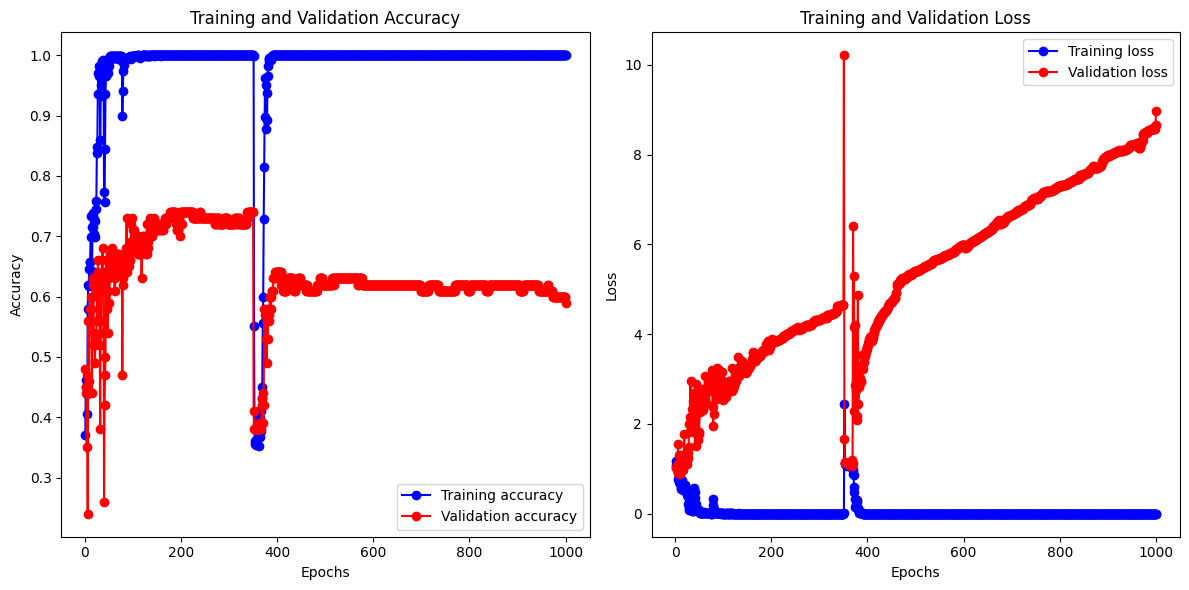

In [10]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss from the history object
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [8]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, val_labels_one_hot)
print(f'Validation Accuracy: {accuracy:.4f}')

# Example of making predictions on the validation set
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)

# Convert predicted classes back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Display the first 10 predictions
for i in range(10):
    print(f'Text: {val_texts[i]}')
    print(f'Predicted Label: {predicted_labels[i]}')
    print(f'Actual Label: {val_labels[i]}')
    print('---')

4/4 [==============================] - 0s 5ms/step - loss: 8.9682 - accuracy: 0.5900
Validation Accuracy: 0.5900
4/4 [==============================] - 0s 4ms/step
Text: Jika ada pertanyaan lebih lanjut yang ingin kamu ketahui atau mengalami kendala terkait dengan produk traveloka, jangan ragu untuk menghubungi kami kembali.
Predicted Label: positive
Actual Label: neutral
---
Text: Rasanya sih kok harga kaki lima dan rasanya ya tidak jauh dari situ ya. Tempatnya saja sih bentuknya restoran, kalau soal rasa. Ya gitulah.
Predicted Label: positive
Actual Label: negative
---
Text: Minimal cek pesan saya, ada problem yang rumit, detailnya ada di DM
Predicted Label: neutral
Actual Label: neutral
---
Text: Dulu restoran ini merupakan favorit saya karena harganya yang relatif dijangkau dan rasanya yang lumayan. Namun sekarang, sepertinya ada penurunan rasa dari makanannya sehingga tidak spesial lagi. Kadang-kadang kalau sedang penuh, kita harus reserved tempat dan juga yang agak mengganggu ada

# test

In [11]:
from keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Load the pre-trained model from the saved file
model = load_model('sentimen_rnn_val_accuracy_0.7400.h5')  # Replace with the correct file path

# Load the test CSV file
test_data = pd.read_csv('datasets/sentiment/indonesian/test.csv')

# Ensure your CSV has 'text' and 'label' columns
test_texts = test_data['text'].values
test_labels = test_data['label'].values

# Preprocess the labels using the same Label Encoder
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)  # Use the same encoder as in training
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=len(label_encoder.classes_))



In [12]:
# Tokenize the test texts using the same tokenizer fitted on training data
tokenizer = Tokenizer()  # Make sure you use the same tokenizer or load it if necessary
tokenizer.fit_on_texts(train_texts)  # Assuming `train_texts` is still accessible, or load it similarly

test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to ensure uniform input size
max_length = max(len(seq) for seq in train_sequences + val_sequences)  # Set the max_length used during training, or adjust based on training
X_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')


In [13]:

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, test_labels_one_hot)
print(f'Test Accuracy: {accuracy:.4f}')


13/13 [==============================] - 0s 6ms/step - loss: 5.5465 - accuracy: 0.6000
Test Accuracy: 0.6000


In [14]:

# Make predictions on the test set
test_predictions = model.predict(X_test)
predicted_test_classes = np.argmax(test_predictions, axis=1)

# Convert predicted classes back to original labels
predicted_test_labels = label_encoder.inverse_transform(predicted_test_classes)

# Display the first 10 predictions for test data
for i in range(10):
    print(f'Text: {test_texts[i]}')
    print(f'Predicted Label: {predicted_test_labels[i]}')
    print(f'Actual Label: {test_labels[i]}')
    print('---')


13/13 [==============================] - 0s 5ms/step
Text: Dekat dengan hotel saya menginap, hanya ditempuh jalan kaki, di sini banyak sekali pilihan makanannya, tempat yang luas, dan menyenangkan
Predicted Label: neutral
Actual Label: positive
---
Text: Iya benar, dia sedang jaga warung.
Predicted Label: neutral
Actual Label: neutral
---
Text: Kangkungnya lumayan tapi kepiting saus padangnya mengecewakan kami dikasih kepiting yang kopong akhir kami tidak makan keptingnya dan dikembalikan.
Predicted Label: negative
Actual Label: negative
---
Text: Bertempat di braga city walk yang satu gedung dengan aston dan fave hotel, tempat ini sangat nyaman buat kongkow-kongkow. Kopi campur teh yang baru pertama kali saya nikmati ternyata sangat enak, dipadu dengan telur setengah matang menjadi pendamping mengobrol bersama teman-teman. Area yang bebas merokok semakin mengasyikkan sambil menikmati pemandangan lalu lalang orang-orang yang keluar masuk mal ini.
Predicted Label: positive
Actual Label:

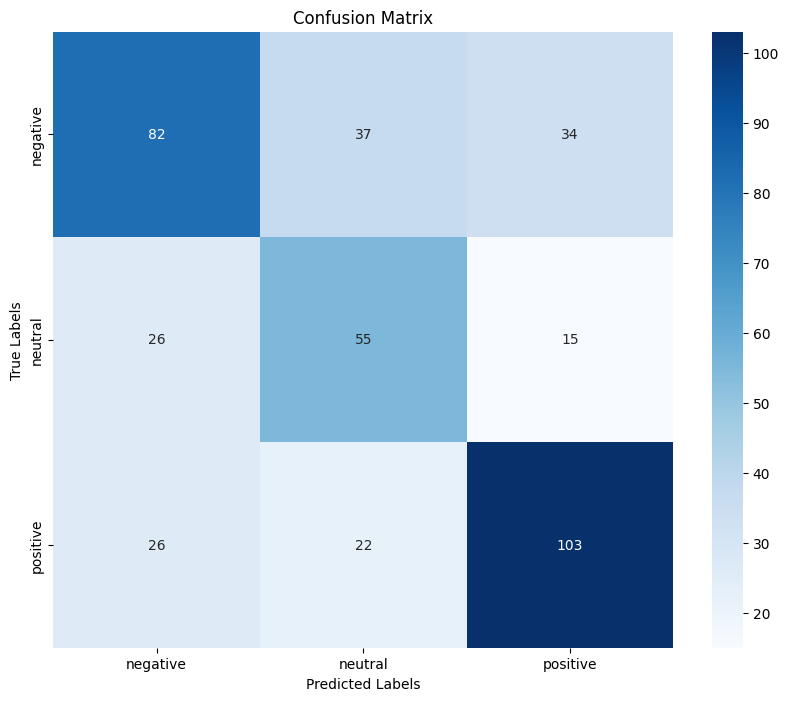

              precision    recall  f1-score   support

    negative       0.61      0.54      0.57       153
     neutral       0.48      0.57      0.52        96
    positive       0.68      0.68      0.68       151

    accuracy                           0.60       400
   macro avg       0.59      0.60      0.59       400
weighted avg       0.61      0.60      0.60       400



In [15]:

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, predicted_test_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print(classification_report(test_labels_encoded, predicted_test_classes, target_names=label_encoder.classes_))
